In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os 
import glob
%matplotlib inline

### Explore Test Data

In [3]:
test_files = glob.glob('test_images/*.jpg')

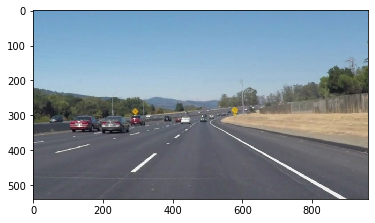

In [12]:
test_image = mpimg.imread(test_files[5])
plt.imshow(test_image)

### Helper Functions

In [88]:
def apply_gaussian_blur(gray, ksize):
    """ Applies a Gaussian Noise Kernel """
    return cv2.GaussianBlur(gray, (ksize, ksize), 0)


def apply_canny(gray, low_threshold, high_threshold):
    """ Applies the Canny transform """
    return cv2.Canny(gray, low_threshold, high_threshold)


def region_of_interest(img, vertices):
    """
    Applies an image mask
    
    Only keeps the region of the image defined by the polygon formed from 'vertices'.
    The rest of the image is set to black. 
    `vertices` should be a numpy array of integer points
    """
    
    # define a blank mask to start with
    mask = np.zeros_like(img)
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
      
    
def apply_hough_lines(gray, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform. 
    
    Returns an image with hough lines drawn. 
    """
    lines = cv2.HoughLinesP(gray, 
                            rho, 
                            theta, 
                            threshold, 
                            min_line_len, 
                            max_line_gap)
    H, W = gray.shape[:2]
    mask_lines = np.zeros((H, W, 3), dtype=np.uint8)
    draw_lines(mask_lines, lines)
    return mask_lines


def weighted_img(initial_img, mask_lines, alpha=0.8, beta=1., gamma=0.):
    """
    `mask_lines`: is the output of the apply_hough_lines(), An image with lines draw on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img`: should be the image before any processing. 
    
    The result image is computed as follows:
    initial_img * alpha + img * beta + gamma
    
    Note: initial_img and img must be the same shape
    
    """
    return cv2.addWeighted(initial_img, alpha, mask_lines, beta, gamma)

### pipeline

In [89]:
def detect_lane_lines(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
        
    H, W = gray.shape
    
    # 高斯模糊
    gray = apply_gaussian_blur(gray, ksize=3)
    
    # 使用 Canny 检测边缘
    edges = apply_canny(gray, 50, 150)
    
    # 获得 ROI
    vertices = np.array([[(0.51 * W, 0.58 * H),
                          (0.49 * W, 0.58 * H),
                          (0, H),
                          (W, H)]], dtype=np.int32)
    
    roi = region_of_interest(edges, vertices)
    
    # 霍夫变换
    mask_lines = apply_hough_lines(gray=roi, 
                                   rho=1, 
                                   theta=np.pi/180,
                                   threshold=35,
                                   min_line_len=5,
                                   max_line_gap=2)
    
    # 画线
    result = weighted_img(image, mask_lines)
    return result

In [91]:
out_root = 'output_images'

if not os.path.exists(out_root):
    os.makedirs(out_root)
    
lane_images = []
    
for fpath in test_files:
    image = mpimg.imread(fpath)
    lane_image = detect_lane_lines(image)
    lane_images.append(lane_image)
    
    rgb_image = cv2.cvtColor(lane_image, cv2.COLOR_RGB2BGR)
    save_path = os.path.join(out_root, os.path.basename(fpath))
    cv2.imwrite(save_path, rgb_image)

### Test on Videos

In [93]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [95]:
video_out = 'output_videos'

if not os.path.exists(video_out):
    os.makedirs(video_out)

test_video_paths = glob.glob('test_videos/*.mp4')
print(test_video_paths)

['test_videos/solidWhiteRight.mp4', 'test_videos/challenge.mp4', 'test_videos/solidYellowLeft.mp4']


In [100]:
white_path = test_video_paths[0]
clip1 = VideoFileClip(white_path).subclip(0, 5)
white_clip = clip1.fl_image(detect_lane_lines)
white_output = os.path.join(video_out, os.path.basename(white_path))
%time white_clip.write_videofile(white_output, audio=False)

t:  13%|█▎        | 16/125 [00:00<00:00, 152.75it/s, now=None]

Moviepy - Building video output_videos/solidWhiteRight.mp4.
Moviepy - Writing video output_videos/solidWhiteRight.mp4




t:   2%|▏         | 2/125 [00:22<22:36, 11.03s/it, now=None]   

Moviepy - Done !
Moviepy - video ready output_videos/solidWhiteRight.mp4
CPU times: user 1.07 s, sys: 609 ms, total: 1.68 s
Wall time: 1.13 s


In [101]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Improve 

In [121]:
def average_slope_intercept(lines):
    left_lines    = []  # (slope, intercept)  
    left_weights  = []  # (length, )
    right_lines   = []  # (slope, intercept)
    right_weights = []  # (length, )
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue # ignore a vertical line
                
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
            
            if slope < 0:  # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
                
    # add more weight to longer lines
    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights)
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights)
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

In [113]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it.
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [114]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0]  # bottom of the image
    y2 = y1 * 0.6        # slightly lower than the middle
    
    left_line = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

In [118]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    """
    make a separate image to draw lines and combine with the original later
    """
    mask = np.zeros_like(image)
    
    for line in lines:
        if line is not None:
            cv2.line(mask, *line, color, thickness)
    
    return cv2.addWeighted(image, 1.0, mask, 0.95, 0.0)

In [116]:
def detect_lane_lines2(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
        
    H, W = gray.shape
    
    # 高斯模糊
    gray = apply_gaussian_blur(gray, ksize=3)
    
    # 使用 Canny 检测边缘
    edges = apply_canny(gray, 50, 150)
    
    # 获得 ROI
    vertices = np.array([[(0.51 * W, 0.58 * H),
                          (0.49 * W, 0.58 * H),
                          (0, H),
                          (W, H)]], dtype=np.int32)
    
    roi = region_of_interest(edges, vertices)
    
    # 霍夫变换
    lines = cv2.HoughLinesP(roi, 
                            rho=1, 
                            theta=np.pi/180, 
                            threshold=20,
                            minLineLength=20,
                            maxLineGap=300)
    
    lines = lane_lines(image, lines)
    
    lane_image = draw_lane_lines(image, lines)
    
    return lane_image

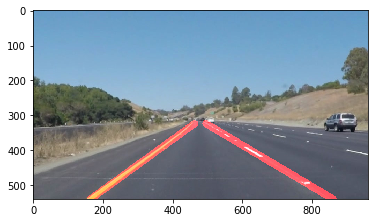

In [122]:
test_image = mpimg.imread(test_files[0])
lane_image = detect_lane_lines2(test_image)
plt.imshow(lane_image)

In [123]:
out_root = 'output_images2'

if not os.path.exists(out_root):
    os.makedirs(out_root)
    
lane_images = []
    
for fpath in test_files:
    image = mpimg.imread(fpath)
    lane_image = detect_lane_lines2(image)
    lane_images.append(lane_image)
    
    rgb_image = cv2.cvtColor(lane_image, cv2.COLOR_RGB2BGR)
    save_path = os.path.join(out_root, os.path.basename(fpath))
    cv2.imwrite(save_path, rgb_image)

In [124]:
yellow_output = 'output_videos/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(detect_lane_lines2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 14/681 [00:00<00:04, 135.88it/s, now=None]

Moviepy - Building video output_videos/solidYellowLeft.mp4.
Moviepy - Writing video output_videos/solidYellowLeft.mp4




t:   2%|▏         | 2/125 [45:47<46:56:12, 1373.76s/it, now=None]A

Moviepy - Done !
Moviepy - video ready output_videos/solidYellowLeft.mp4
CPU times: user 6.25 s, sys: 3.21 s, total: 9.46 s
Wall time: 5.76 s


In [125]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Challenge Video

In [126]:
challenge_output = 'output_videos/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0, 5)
challenge_clip = clip3.fl_image(detect_lane_lines2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   8%|▊         | 10/125 [00:00<00:01, 89.43it/s, now=None]

Moviepy - Building video output_videos/challenge.mp4.
Moviepy - Writing video output_videos/challenge.mp4




t:   2%|▏         | 2/125 [48:55<50:09:10, 1467.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready output_videos/challenge.mp4
CPU times: user 2.44 s, sys: 918 ms, total: 3.36 s
Wall time: 2.35 s


In [127]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))